## Assignment 1 of MAFS6010Y
## Team Name: RandomSeed 
## Write-up
- **Objective**: We use disjoint LinUCB algorithm on the 11 sector ETFs to maximize long-term investment reward by trying to select the best 3 sectors every day.
<br>
- **Data**: 'Dataset.xlsx' contains two sheets. Start from 2005-Jan-03 to 2021-Feb-25. 
<br>Sheet 1: **'Features'.**
<br>Includes 49 US macro-economic indicators such as bond yield, SP500 return, etc. We use past 5d % and last price depending on the data type. All data comes from Bloomberg.
<br>Sheet 2: **'Arm'**
<br>Include 11 sector ETFs, and each data field is the future 5d return.
<br>
- **Methodology**: Disjoint LinUCB algorithm. 




In [1]:
import random
import math
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 100

#parameters
reward_value=1
K_arms = 11
d = 25
n_components = 25  #Explain 85% of variance in PCA analysis

# Data Preprossing

In [2]:
#Get the reward data on each timestep for each arm by ranking the future 5D ret%
targets = pd.read_excel (r'Dataset.xlsx','Arm').iloc[:,1:12]
targets.fillna(method='ffill',inplace=True)
for i in range(len(targets)):
    targets.iloc[i,:]=sorted(range(K_arms), key=lambda x: targets.iloc[i,x])
    for j in range(K_arms):
        if targets.iloc[i,j]>=8: #Best 3 arms get reward 1
            targets.iloc[i,j]= reward_value
        else:
            targets.iloc[i,j]=0
targets.head()

,XLK US Equity (R1),XLV US Equity (R1),VNQ US Equity (R1),XLF US Equity (L1),XLE US Equity (L1),XLB US Equity (L1),XLY US Equity (R1),XLI US Equity (R1),XLU US Equity (L1),XLP US Equity (L1),VOX US Equity (R1)
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [3]:
#Get the feature data on each timestep 
features=pd.read_excel (r'Dataset.xlsx','Feature').iloc[:,1:]
features.fillna(method='ffill',inplace=True)
features.head()

,USGG10YR Index (USD) (R1),USGGT10Y Index (USD) (R1),US00O/N Index (USD) (R1),US0003M Index (USD) (R1),FEDL01 Index (USD) (R1),GSUSFCI Index (USD) (R1),NYSEVOL Index (USD) (R3),SMART Index (USD) (R2),EPUCNUSD Index (USD) (L3),XAU Curncy (USD) (R2),...,MDY US Equity (USD),SPY US Equity (USD),RSP US Equity (USD),QQQ US Equity (USD),IWB US Equity (USD),IWM US Equity (USD),QQQ US Equity (USD).1,QTEC US Equity (USD),IWB US Equity (USD).1,IWM US Equity (USD).1
0,4.21040,1.6496,0.00000,0.00,2.31,-0.0201,63.673,-0.7143,247.25,-3.70,...,-0.0501,-0.1825,-0.2591,-0.2299,-0.3860,-0.4129,-0.1026,-0.5302,-0.5544,-0.1119
1,4.28863,1.7162,2.31875,2.57,2.25,0.1410,78.326,-1.4425,409.49,-3.65,...,-2.9715,-1.9393,-2.4602,-2.9772,-2.1632,-3.8216,-2.3592,-2.0752,-1.9793,-1.9857
2,4.28078,1.7337,2.32000,2.59,2.25,0.1410,83.175,-1.7791,27.59,-2.07,...,-4.3851,-2.7604,-3.3607,-3.6982,-2.4992,-5.7367,-3.0297,-2.6039,-2.3276,-2.7100
3,4.26117,1.7090,2.31750,2.61,2.25,0.2216,85.512,-1.4777,-75.49,-3.54,...,-3.8065,-2.0804,-3.2582,-4.1085,-2.3598,-4.9004,-2.1602,-1.9005,-1.9327,-1.9246
4,4.26900,1.7423,2.29875,2.61,2.24,0.2418,93.792,-1.3601,-86.92,-4.69,...,-4.1157,-2.0104,-3.4772,-3.4198,-2.0480,-5.8996,-2.3398,-2.3655,-1.6277,-2.1310


# Feature PCA Analysis

In [4]:
feature_names = features.columns
variables = features.iloc[:,0:]
variables = StandardScaler().fit_transform(variables)
pd.DataFrame(data = variables, columns = feature_names).head()

,USGG10YR Index (USD) (R1),USGGT10Y Index (USD) (R1),US00O/N Index (USD) (R1),US0003M Index (USD) (R1),FEDL01 Index (USD) (R1),GSUSFCI Index (USD) (R1),NYSEVOL Index (USD) (R3),SMART Index (USD) (R2),EPUCNUSD Index (USD) (L3),XAU Curncy (USD) (R2),...,MDY US Equity (USD),SPY US Equity (USD),RSP US Equity (USD),QQQ US Equity (USD),IWB US Equity (USD),IWM US Equity (USD),QQQ US Equity (USD).1,QTEC US Equity (USD),IWB US Equity (USD).1,IWM US Equity (USD).1
0,1.253545,0.904574,-0.815330,-0.971906,0.566797,-0.119325,1.686697,-0.407093,1.716045,-1.562253,...,-0.095363,-0.161688,-0.173148,-0.199180,-0.244921,-0.198799,-0.145072,-0.270814,-0.335661,-0.109714
1,1.324160,0.975113,0.531274,0.527285,0.531315,0.884720,2.105179,-0.830612,2.947864,-1.542174,...,-1.081418,-0.882813,-0.964600,-1.209325,-0.966697,-1.256093,-1.064398,-0.863058,-0.936655,-0.830899
2,1.317074,0.993647,0.532000,0.538952,0.531315,0.884720,2.243664,-1.026377,0.048260,-0.907670,...,-1.558548,-1.219855,-1.288394,-1.474426,-1.103157,-1.850109,-1.337556,-1.065725,-1.083561,-1.109666
3,1.299373,0.967487,0.530548,0.550619,0.531315,1.387054,2.310407,-0.851084,-0.734382,-1.498000,...,-1.363254,-0.940731,-1.251538,-1.625288,-1.046542,-1.590709,-0.983327,-0.796091,-0.917000,-0.807382
4,1.306441,1.002756,0.519659,0.550619,0.525401,1.512950,2.546880,-0.782688,-0.821165,-1.959822,...,-1.467618,-0.911998,-1.330284,-1.372063,-0.919911,-1.900636,-1.056495,-0.974339,-0.788357,-0.886821


In [5]:
pca = PCA(n_components)
principalComponents = pca.fit_transform(variables)
PCA_index = pd.DataFrame(pca.components_,columns=feature_names,index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
PCA_index.head()
pca.explained_variance_ratio_

array([0.35832957, 0.10970532, 0.08638321, 0.04673287, 0.04062429,
       0.02928626, 0.02750199, 0.02037074, 0.01993878, 0.01951547,
       0.01882462, 0.01853791, 0.01737753, 0.01597499, 0.01451672,
       0.01402401, 0.01253193, 0.01184727, 0.01114949, 0.01076354,
       0.01032824, 0.00957363, 0.00923413, 0.00866736, 0.00765158])

In [6]:
features_array=np.dot(features,PCA_index.T)
features = pd.DataFrame(features_array)

In [7]:
np.shape(features)

(4039, 25)

# Function to generate multiple dataset from real data (for recycle purpose)

In [8]:

def generate_data(num_of_times):  
    
    data=pd.DataFrame()
    for times in range(num_of_times):
        arm = []
        reward = []
        for i in range(len(targets)):
            x=np.random.choice(K_arms)
            arm.append(x)
            reward.append([targets.iloc[i,x]])
        
        arm=pd.DataFrame(arm)
        reward=pd.DataFrame(reward)
        df1=pd.concat([arm,reward,features],axis=1)    # get random arm choices and corresponding reward
        data=pd.concat([data,df1],axis=0)
    return data

# Testing Module

In [9]:
def test_algorithm(K_arms,d,alpha,num_draws):
    linucb_policy_object = linucb_policy(K_arms = K_arms, d = d, alpha = alpha)
    aligned_time_steps=0
    cumulative_rewards = 0
    aligned_rewards = []
    data=generate_data(num_draws)
    
    for t in range(len(data)):
        
        data_arm = data.iloc[t,0]
        data_reward = data.iloc[t,1]
        covariate_string_list = data.iloc[t,2:]
        data_x_array = np.array([float(x) for x in covariate_string_list])
        arm_index = linucb_policy_object.select_arm(data_x_array)
        
        if arm_index == data_arm:
            
            linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)
            aligned_time_steps += 1
            cumulative_rewards += data_reward
            aligned_rewards.append(cumulative_rewards/aligned_time_steps)
    
                    
    return (aligned_time_steps, cumulative_rewards, aligned_rewards)

# Single linear ucb disjoint arm

In [10]:
class linucb_disjoint_arm():
    
    def __init__(self,arm_index,d,alpha):
        self.arm_index=arm_index
        self.alpha=alpha
        self.A=np.identity(d)
        self.b=np.zeros([d,1])
    
    def calc_UCB(self,x_array):
        A_inv=np.linalg.inv(self.A)
        self.theta=np.dot(A_inv,self.b)
        x=x_array.reshape([-1,1])
        p = np.dot(self.theta.T,x) +  self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
        return p
    
    def reward_update(self,reward,x_array):
        x = x_array.reshape([-1,1])
        self.A += np.dot(x, x.T)
        self.b += reward * x
        

# k-linear ucb disjoint arm

In [11]:
class linucb_policy():
    
    def __init__(self, K_arms,d,alpha):
        self.K_arms=K_arms
        self.linucb_arms=[linucb_disjoint_arm(arm_index=i,d=d,alpha=alpha) for i in range(K_arms)]
    
    def select_arm(self,x_array):
        highest_ucb=-1
        candidate_arms=[]
        for arm_index in range(self.K_arms):
            arm_ucb=self.linucb_arms[arm_index].calc_UCB(x_array)
            if arm_ucb > highest_ucb:
                highest_ucb=arm_ucb
                candidate_arms = [arm_index]
            if arm_ucb == highest_ucb:
                candidate_arms.append(arm_index)
        chosen_arm = np.random.choice(candidate_arms)
        return chosen_arm
                

## Testing when alpha = 10

In [22]:
alpha_input=5
aligned_time_steps, cum_rewards, aligned_rewards = test_algorithm(K_arms = K_arms, d = d, alpha = alpha_input, num_draws=100)

Final performance is 0.29,Benchmark performance is 0.27,improves 5.1%


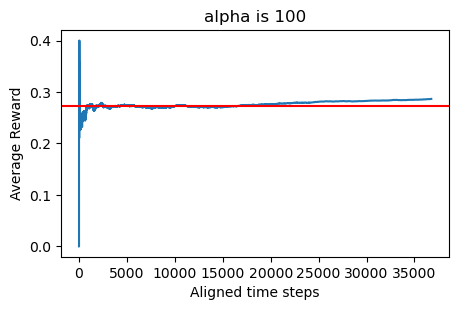

In [21]:
plt.plot(aligned_rewards)
plt.axhline(y=3/11,color='red')
plt.title('alpha is '+str(alpha_input))
plt.xlabel('Aligned time steps')
plt.ylabel('Average Reward')

a=aligned_rewards[-1]
b=3/11
improvement=100*(a-b)/b
print('Final performance is '+ str(round(aligned_rewards[-1],2))+',Benchmark performance is '+ str(round(3/11,2))+',improves '+ str(round(improvement,2))+'%')

## Testing when alpha = 1

In [14]:
alpha_input=1
aligned_time_steps, cum_rewards, aligned_rewards = test_algorithm(K_arms = K_arms, d = d, alpha = alpha_input, num_draws=100)

Final performance is 0.35,Benchmark performance is 0.27,improves 29.48%


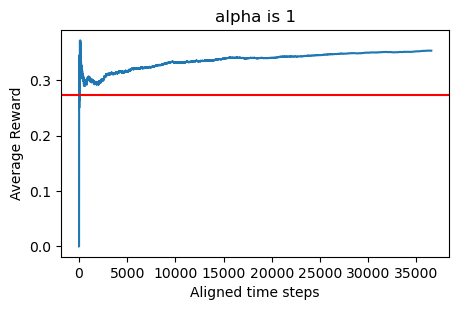

In [15]:
plt.plot(aligned_rewards)
plt.axhline(y=3/11,color='red')
plt.title('alpha is '+str(alpha_input))
plt.xlabel('Aligned time steps')
plt.ylabel('Average Reward')

a=aligned_rewards[-1]
b=3/11
improvement=100*(a-b)/b
print('Final performance is '+ str(round(aligned_rewards[-1],2))+',Benchmark performance is '+ str(round(3/11,2))+',improves '+ str(round(improvement,2))+'%')

## Testing when alpha = 0

In [18]:
alpha_input=0.5
aligned_time_steps, cum_rewards, aligned_rewards = test_algorithm(K_arms = K_arms, d = d, alpha = alpha_input, num_draws=100)

Final performance is 0.35,Benchmark performance is 0.27,improves 28.74%


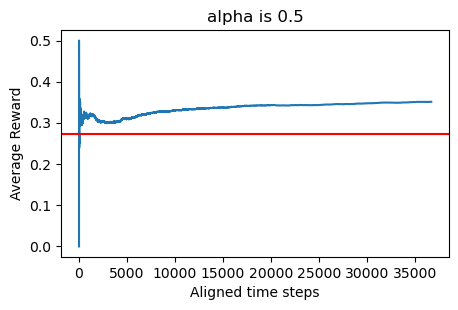

In [19]:
plt.plot(aligned_rewards)
plt.axhline(y=3/11,color='red')
plt.title('alpha is '+str(alpha_input))
plt.xlabel('Aligned time steps')
plt.ylabel('Average Reward')

a=aligned_rewards[-1]
b=3/11
improvement=100*(a-b)/b
print('Final performance is '+ str(round(aligned_rewards[-1],2))+',Benchmark performance is '+ str(round(3/11,2))+',improves '+ str(round(improvement,2))+'%')